# Imports

In [98]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, GRU
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint

from tqdm import tqdm


[]
Num GPUs Available:  0


# Load dataset

In [99]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

# Configuration
MERGE_SIMILAR_SHOTS = True  # Set to True to merge similar shot types like serve/overhead

def merge_shot_classes(shot_type, merge_similar=True):
    """Merge similar shot classes if requested"""
    if not merge_similar:
        return shot_type
    
    # Define shot type mappings
    shot_mappings = {
        'overhead': 'serve',  # Merge overhead into serve
        'smash': 'serve',     # Merge smash into serve (if exists)
    }
    
    return shot_mappings.get(shot_type, shot_type)

X=[]
y=[]

# Updated to new dataset structure - CSV files are directly in the folder, not in a shots/ subdirectory
train_folders = [
    "Emma Raducanu Court Level Practice 2024 (4K 60FPS)", 
    "Emma Raducanu ｜ Court Level Practice [4k 60fps]", 
    "Novak Djokovic Volley & Smash Training Court Level View - ATP Tennis Practice", 
    "World No.1 Iga Swiatek 2024 Court Level Practice with Caroline Garcia (4K 60FPS)",
    "jsinner_h264",
    "jsinner2_h264"
]

test_folders = ["Novak Djokovic & Alexander Zverev Condensed Court Level Practice 2024 4K 60FPS"]

print("Loading training data...")
for folder in train_folders:
    dataset_path = f"dataset/{folder}"
    if not os.path.exists(dataset_path):
        print(f"Warning: {dataset_path} doesn't exist, skipping...")
        continue
        
    print(f"Loading shots from {dataset_path}")
    
    # Check if it's new structure (CSV files directly) or old structure (shots/ subdirectory)
    csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
    shots_path = os.path.join(dataset_path, "shots")
    
    if csv_files:
        # New structure - CSV files directly in folder
        for shot_csv in tqdm(sorted(csv_files)):
            data = pd.read_csv(os.path.join(dataset_path, shot_csv))
            
            # Extract shot type from filename
            name_parts = shot_csv.replace('.csv', '').split('_')
            
            # Handle multi-word shot types (volley, slice, etc.)
            if len(name_parts) >= 3 and name_parts[1] in ['volley', 'slice']:
                shot_type = f"{name_parts[0]}_{name_parts[1]}"
            else:
                shot_type = name_parts[0]
            
            # Apply shot merging if requested
            shot_type = merge_shot_classes(shot_type, MERGE_SIMILAR_SHOTS)
            
            features = data.loc[:, data.columns != 'shot']
            X.append(features.to_numpy())
            y.append(shot_type)
            
    elif os.path.exists(shots_path):
        # Old structure - CSV files in shots/ subdirectory
        for shot_csv in tqdm(sorted(os.listdir(shots_path))):
            if not shot_csv.endswith('.csv'):
                continue
            data = pd.read_csv(os.path.join(shots_path, shot_csv))
            
            # For old structure, shot type should be in the data
            if 'shot' in data.columns:
                shot_type = data["shot"].iloc[0]
            else:
                # Extract from filename as fallback
                name_parts = shot_csv.replace('.csv', '').split('_')
                shot_type = name_parts[0]
            
            # Apply shot merging if requested
            shot_type = merge_shot_classes(shot_type, MERGE_SIMILAR_SHOTS)
            
            features = data.loc[:, data.columns != 'shot']
            X.append(features.to_numpy())
            y.append(shot_type)

# Load test data
X_test=[]
y_test=[]

print("\nLoading test data...")
for folder in test_folders:
    dataset_path = f"dataset/{folder}"
    if not os.path.exists(dataset_path):
        print(f"Warning: {dataset_path} doesn't exist, skipping...")
        continue
        
    print(f"Loading test shots from {dataset_path}")
    
    # Check structure type
    csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
    shots_path = os.path.join(dataset_path, "shots")
    
    if csv_files:
        # New structure
        for shot_csv in tqdm(sorted(csv_files)):
            data = pd.read_csv(os.path.join(dataset_path, shot_csv))
            
            name_parts = shot_csv.replace('.csv', '').split('_')
            if len(name_parts) >= 3 and name_parts[1] in ['volley', 'slice']:
                shot_type = f"{name_parts[0]}_{name_parts[1]}"
            else:
                shot_type = name_parts[0]
            
            shot_type = merge_shot_classes(shot_type, MERGE_SIMILAR_SHOTS)
            
            features = data.loc[:, data.columns != 'shot']
            X_test.append(features.to_numpy())
            y_test.append(shot_type)
            
    elif os.path.exists(shots_path):
        # Old structure
        for shot_csv in tqdm(sorted(os.listdir(shots_path))):
            if not shot_csv.endswith('.csv'):
                continue
            data = pd.read_csv(os.path.join(shots_path, shot_csv))
            
            if 'shot' in data.columns:
                shot_type = data["shot"].iloc[0]
            else:
                name_parts = shot_csv.replace('.csv', '').split('_')
                shot_type = name_parts[0]
            
            shot_type = merge_shot_classes(shot_type, MERGE_SIMILAR_SHOTS)
            
            features = data.loc[:, data.columns != 'shot']
            X_test.append(features.to_numpy())
            y_test.append(shot_type)

# Convert to numpy arrays
if len(X) > 0:
    X = np.stack(X, axis=0)
    y = np.array(y)
    print(f"Loaded {len(y)} shots for training")
else:
    print("No training data loaded!")

if len(X_test) > 0:
    X_test = np.stack(X_test, axis=0)
    y_test = np.array(y_test)
    print(f"Loaded {len(y_test)} shots for test")
else:
    print("No test data loaded!")

# Print unique shot types
print(f"\nUnique shot types in training: {np.unique(y)}")
if len(y_test) > 0:
    print(f"Unique shot types in test: {np.unique(y_test)}")

print(f"\nShot merging {'enabled' if MERGE_SIMILAR_SHOTS else 'disabled'}")
    

Loading training data...
Loading shots from dataset/Emma Raducanu Court Level Practice 2024 (4K 60FPS)


100%|██████████| 256/256 [00:00<00:00, 1759.09it/s]


Loading shots from dataset/Emma Raducanu ｜ Court Level Practice [4k 60fps]


100%|██████████| 319/319 [00:00<00:00, 1818.06it/s]


Loading shots from dataset/Novak Djokovic Volley & Smash Training Court Level View - ATP Tennis Practice


100%|██████████| 107/107 [00:00<00:00, 1830.42it/s]


Loading shots from dataset/World No.1 Iga Swiatek 2024 Court Level Practice with Caroline Garcia (4K 60FPS)


100%|██████████| 181/181 [00:00<00:00, 1836.37it/s]


Loading shots from dataset/jsinner_h264


100%|██████████| 578/578 [00:00<00:00, 1827.54it/s]


Loading shots from dataset/jsinner2_h264


100%|██████████| 459/459 [00:00<00:00, 1835.26it/s]



Loading test data...
Loading test shots from dataset/Novak Djokovic & Alexander Zverev Condensed Court Level Practice 2024 4K 60FPS


100%|██████████| 295/295 [00:00<00:00, 1829.22it/s]

Loaded 1900 shots for training
Loaded 295 shots for test

Unique shot types in training: ['backhand' 'backhand_slice' 'backhand_volley' 'forehand'
 'forehand_volley' 'neutral' 'serve']
Unique shot types in test: ['backhand' 'backhand_slice' 'backhand_volley' 'forehand'
 'forehand_volley' 'neutral' 'serve']

Shot merging enabled


# Display shot repartition

[np.str_('backhand'), np.str_('backhand_volley'), np.str_('backhand_slice'), np.str_('serve'), np.str_('forehand_volley'), np.str_('neutral'), np.str_('forehand')] [269, 51, 39, 122, 51, 930, 438]


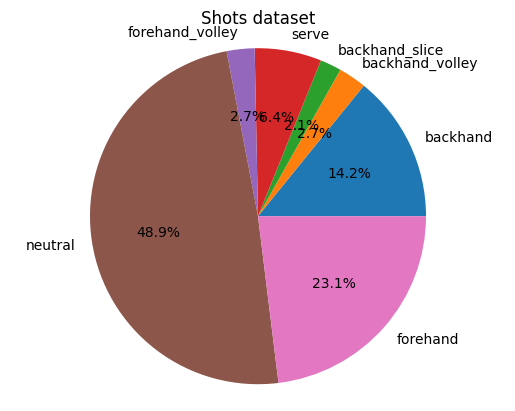

In [100]:
import numpy as np
# if using a Jupyter notebook, include:
%matplotlib inline

shots = list(set(y))
occurences = [np.count_nonzero(y == shot) for shot in shots]
print(shots, occurences)

fig, ax = plt.subplots()
ax.pie(occurences, labels=shots, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Shots dataset')


plt.show()

In [101]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, shuffle= True)


print(f"Shape of train features : {X_train[0].shape}")
print(f"Shape of val features : {X_val[0].shape}")

print("Total categories: ", len(np.unique(y_train)))
print("Total categories: ", len(np.unique(y_val)))

nb_cat = len(np.unique(y_train))

Shape of train features : (30, 26)
Shape of val features : (30, 26)
Total categories:  7
Total categories:  7


In [102]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
# Save raw labels for computing class weights
y_train_raw = y_train.copy()
y_val = le.transform(y_val)
y_test = le.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_cat)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=nb_cat)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_cat)

y_train = np.array(y_train)
X_train = np.array(X_train)
#X_train = np.expand_dims(X_train, axis=-1)

y_val = np.array(y_val)
X_val = np.array(X_val)
#X_val = np.expand_dims(X_val, axis=-1)

y_test = np.array(y_test)
X_test = np.array(X_test)


In [104]:

print(le.classes_)
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_raw),
                                     y=y_train_raw)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

['backhand' 'backhand_slice' 'backhand_volley' 'forehand'
 'forehand_volley' 'neutral' 'serve']
Class weights: {0: np.float64(1.0103174603174603), 1: np.float64(7.906832298136646), 2: np.float64(5.683035714285714), 3: np.float64(0.6164648910411622), 4: np.float64(4.663003663003663), 5: np.float64(0.2891210538269362), 6: np.float64(2.4247619047619047)}


In [105]:
print("X_train Shape: ", X_train.shape)
print("X_val Shape: ", X_val.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_val Shape: ", y_val.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (1273, 30, 26)
X_val Shape:  (627, 30, 26)
X_test Shape:  (295, 30, 26)
y_train Shape:  (1273, 7)
y_val Shape:  (627, 7)
y_test Shape:  (295, 7)


In [106]:
m1=Sequential()
m1.add(GRU(units=24, dropout=0.1, input_shape=( 30, 26)))
m1.add(Dropout(0.2))
m1.add(Dense(units = 8, activation = 'relu'))
m1.add(Dense(units = nb_cat, activation = 'softmax'))

/home/manojos/btp/tennis_shot_recognition/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [107]:
m1.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
m1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 24)             │         3,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,007 (15.65 KB)

 Trainable params: 4,007 (15.65 KB)

 Non-trainable params: 0 (0.00 B)

In [108]:
filepath = "weights.keras"
checkpointer = ModelCheckpoint(filepath=filepath, verbose=False, save_best_only=True)
hist = m1.fit(X_train, y_train,
               validation_data=(X_val, y_val),
               batch_size = 32,
                epochs=300, 
                verbose = 1, 
                callbacks=[checkpointer],
                class_weight=class_weight_dict
             )

loss, accuracy = m1.evaluate(X_val, y_val)
print(f"Accuracy on validation dataset = {accuracy}")

m1.load_weights(filepath)

loss, accuracy = m1.evaluate(X_val, y_val)
print(f"Accuracy on validation dataset = {accuracy}")

Epoch 1/300


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2376 - loss: 2.0120 - val_accuracy: 0.1978 - val_loss: 1.9424
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1091 - loss: 2.1453 - val_accuracy: 0.0973 - val_loss: 1.9477
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1130 - loss: 1.8907 - val_accuracy: 0.0319 - val_loss: 1.9537
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0800 - loss: 1.8938 - val_accuracy: 0.0271 - val_loss: 1.9466
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0343 - loss: 1.9592 - val_accuracy: 0.0415 - val_loss: 1.9661
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0445 - loss: 1.9689 - val_accuracy: 0.0271 - val_loss: 1.9576
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0455 - loss: 1.9203 - val_accuracy: 0.0383 - val_loss: 1.9501
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0739 - loss: 1.9065 - val_accuracy: 0.0383 - val_loss: 1.9

In [109]:
m1.save("tennis_rnn_rafa_diy_balanced.keras")

# Confusion matrix

In [110]:
loss, accuracy = m1.evaluate(X_test, y_test)
print(f"Accuracy on test dataset = {accuracy:.3f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8842 - loss: 0.5253
Accuracy on test dataset = 0.885


In [111]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


preds = m1.predict(X_test)
test_predictions = np.argmax(preds, axis=1)


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


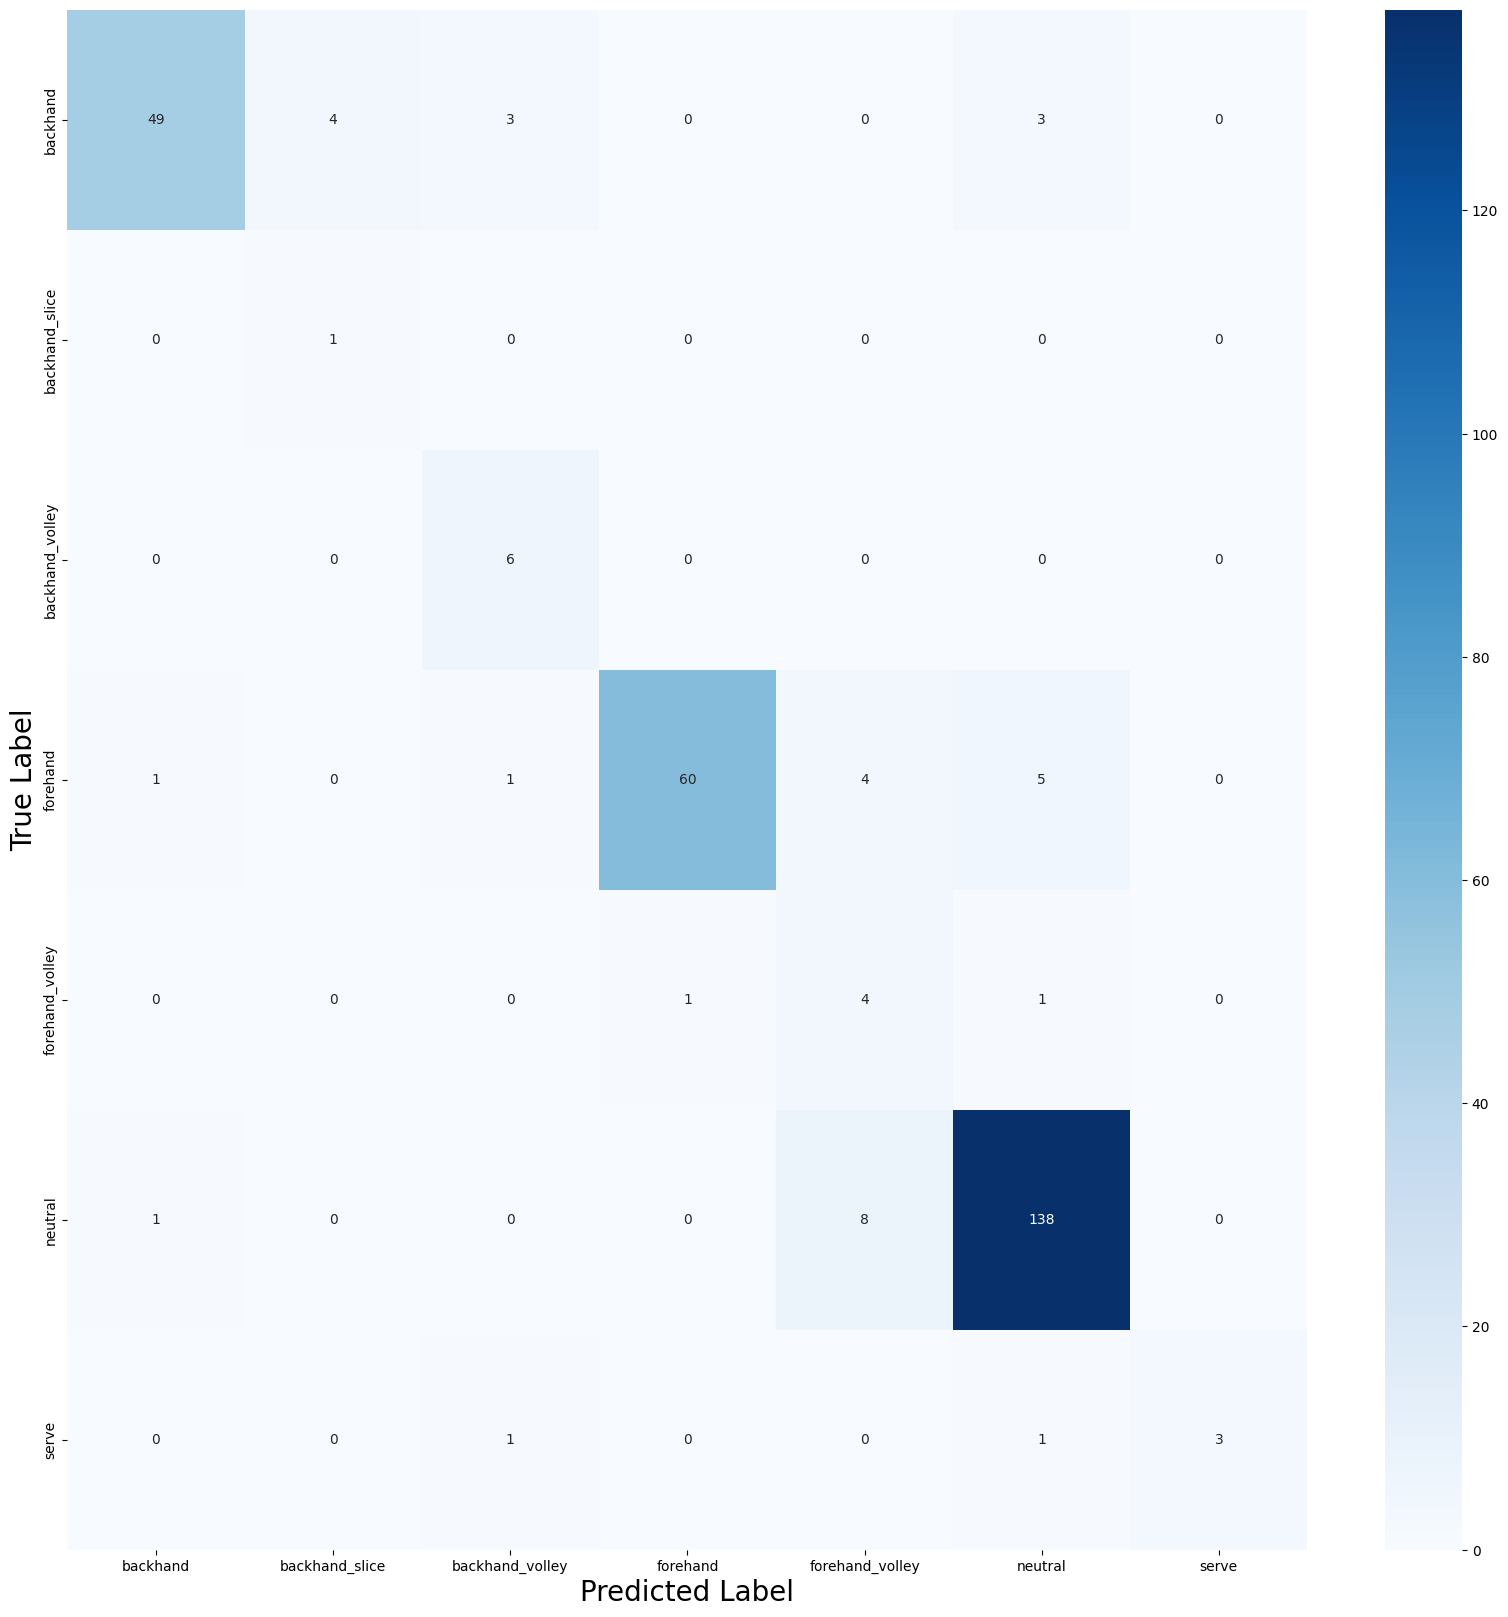

In [112]:
# Plot the confusion matrix
%matplotlib inline


cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=test_predictions)


df_cm = pd.DataFrame(
    cm, index=le.classes_, columns=le.classes_
)
plt.figure(figsize=(20, 20))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.show()

# Display a few examples

In [ ]:
import imageio
from tensorflow_docs.vis import embed

def to_gif(shot):
    height = 500
    width = 500
    
    KEYPOINTS = np.array(["nose",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_hip",
        "right_hip",
        "left_knee",
        "right_knee",
        "left_ankle",
        "right_ankle"])
    
    EDGES = {
        ("nose", "left_shoulder"): "m",
        ("nose", "right_shoulder"): "c",
        ("left_shoulder", "left_elbow"): "m",
        ("left_elbow", "left_wrist"): "m",
        ("right_shoulder", "right_elbow"): "c",
        ("right_elbow", "right_wrist"): "c",
        ("left_shoulder", "right_shoulder"): "y",
        ("left_shoulder", "left_hip"): "m",
        ("right_shoulder", "right_hip"): "c",
        ("left_hip", "right_hip"): "y",
        ("left_hip", "left_knee"): "m",
        ("left_knee", "left_ankle"): "m",
        ("right_hip", "right_knee"): "c",
        ("right_knee", "right_ankle"): "c",
    }
    
    COLORS = {"c": (255, 255, 0), "m": (255, 0, 255), "y": (0, 255, 255)}
    
    
    frames=np.zeros((30, height, width, 3), np.uint8)
    for i in range(len(shot)):
        shot_inst = shot[i, :]
        for k in range(13):
            cv2.circle(
                frames[i],
                (
                    int(shot_inst[2*k+1] * width),
                    int(shot_inst[2*k] * height),
                ),
                radius=3,
                color=(0, 255, 0),
                thickness=-1,
            )
            
        for edge in EDGES.items():
            k = np.argwhere(KEYPOINTS == edge[0][0])[0][0]
            j = np.argwhere(KEYPOINTS == edge[0][1])[0][0]
            cv2.line(
                frames[i],
                (
                    int(shot_inst[2*k+1] * width),
                    int(shot_inst[2*k] * height),
                ),
                (
                    int(shot_inst[2*j+1] * width),
                    int(shot_inst[2*j] * height),
                ),
                color=COLORS[edge[1]],
                thickness=2,
            )
    
    return frames.astype(np.uint8)
        




In [ ]:
import random
k = random.randint(0, len(y_test))

converted_images = to_gif(X_test[k, :, :])
imageio.mimsave("animation.gif", converted_images, fps=15)

print("Predicts:")
for i in range(nb_cat):
    print(f"{le.classes_[i]} = {preds[k, i]*100:.1f}%")
    

print(f"\nGT: {le.classes_[np.argmax(y_test[k])]}")


embed.embed_file("animation.gif")

## A bad classification

In [ ]:
mismatch = np.argwhere(np.argmax(y_test, axis = 1) != test_predictions).flatten()
print(mismatch)

k = mismatch[random.randint(0, len(mismatch) - 1)]

print(k)
converted_images = to_gif(X_test[k, :, :])
imageio.mimsave("animation.gif", converted_images, fps=15)

print("Predicts:")
for i in range(nb_cat):
    print(f"{le.classes_[i]} = {preds[k, i]*100:.1f}%")
    

print(f"\nGT: {le.classes_[np.argmax(y_test[k])]}")


embed.embed_file("animation.gif")